In [1]:
from typing import Annotated
import operator, json
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= os.getenv("LANGSMITH_API_KEY")

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [5]:
@tool
def multiply(first_number:int, second_number:int) -> int:
    """Multiply two integer number"""
    return first_number * second_number

In [6]:
# This is how we call a tool
multiply({"first_number":24, "second_number":10})

C:\Users\Vikas Chauhan\AppData\Local\Temp\ipykernel_22812\2713421913.py:2: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24, "second_number":10})


240

In [7]:
multiply.invoke({"first_number":24, "second_number":10})

240

In [8]:
# We need to put condition on this tool
@tool
def search(query: str):
    """Perform the web search on the user query"""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result

In [9]:
search.invoke("Current president of USA")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\nPresident of the United States\n\nThe president of the United States is the:\n\nCurrent president\n\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\n\nFormer U.S. presidents [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\nCurrent vice president\n\nThe 50th and current vice president of the United States is James David (JD) Vance. He was sworn 

In [10]:
tools = [search, multiply]

In [11]:
llm_with_tools = llm.bind_tools(tools)

In [12]:
# Tool mapping
tool_mapping = {tool.name: tool for tool in tools}

In [13]:
tool_mapping

{'search': StructuredTool(name='search', description='Perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001ACBE95A840>),
 'multiply': StructuredTool(name='multiply', description='Multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001ACBE959760>)}

In [14]:
response = llm_with_tools.invoke("who is the current president of USA?")

In [15]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8m09', 'function': {'arguments': '{"query":"current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 1002, 'total_tokens': 1070, 'completion_time': 0.056666667, 'prompt_time': 0.285431555, 'queue_time': 0.249189865, 'total_time': 0.342098222}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b75393fe-6745-44a0-aac4-207d53f8b261-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of USA'}, 'id': 'call_8m09', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1002, 'output_tokens': 68, 'total_tokens': 1070})

In [16]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'current president of USA'},
  'id': 'call_8m09',
  'type': 'tool_call'}]

In [17]:
tool_details = response.additional_kwargs.get("tool_calls")
tool_details

[{'id': 'call_8m09',
  'function': {'arguments': '{"query":"current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [18]:
tool_details[0]['function']['name']

'search'

In [19]:
tool_details[0]['function']['arguments']

'{"query":"current president of USA"}'

In [20]:
tool_mapping[tool_details[0]['function']['name']].invoke(json.loads(tool_details[0]['function']['arguments']))

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\nPresident of the United States\n\nThe president of the United States is the:\n\nCurrent president\n\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\n\nFormer U.S. presidents [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\nCurrent vice president\n\nThe 50th and current vice president of the United States is James David (JD) Vance. He was sworn 

In [21]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [22]:
def invoke_model(state: AgentState):
    messages = state['messages']
    question = messages[-1]
    return {"messages": [llm_with_tools.invoke(question)]}

In [23]:
# Main part of Human in the loop
def invoke_tool(state:AgentState):
    tool_details = state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f"Selected tool: {tool_details.get("function").get("name")}")
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search")
        if response == "n":
            raise Exception("Web search discard")

In [24]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [25]:
workflow = StateGraph(AgentState)
workflow.add_node("ai_assistant", invoke_model)
workflow.add_node("tool", invoke_tool)
workflow.add_conditional_edges("ai_assistant", router, {"tool":"tool", "end":END})
workflow.add_edge("tool", END)
workflow.set_entry_point("ai_assistant")
app = workflow.compile()

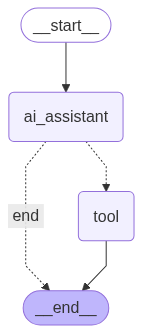

In [26]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
for s in app.stream({"messages": ["Who is current president of USA?"]}):
    print(list(s.values())[0])
    print("-----------")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nmp9', 'function': {'arguments': '{"query":"current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 1001, 'total_tokens': 1076, 'completion_time': 0.0625, 'prompt_time': 0.187593913, 'queue_time': 0.45847329, 'total_time': 0.250093913}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ab12f62b-7b4d-49c7-9a85-a41aad90233c-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of USA'}, 'id': 'call_nmp9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1001, 'output_tokens': 75, 'total_tokens': 1076})]}
-----------
Selected tool: search
None
-----------


In [28]:
for s in app.stream({"messages": ["What is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("-----------")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_txpa', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 1004, 'total_tokens': 1078, 'completion_time': 0.061666667, 'prompt_time': 0.227759448, 'queue_time': 3.089708414, 'total_time': 0.289426115}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--61c0f0d4-ed3b-49db-8ae3-a200c7d5312e-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_txpa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1004, 'output_tokens': 74, 'total_tokens': 1078})]}
-----------
Selected tool: multiply
None
-----------


In [ ]:
for s in app.stream({"messages": ["Hi how are you?"]}):
    print(list(s.values())[0])
    print("-----------")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_963t', 'function': {'arguments': '{"query":"how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 999, 'total_tokens': 1066, 'completion_time': 0.055833333, 'prompt_time': 0.125277046, 'queue_time': 0.253735811, 'total_time': 0.181110379}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8ed4eee9-856e-455b-a074-5b0d305ee776-0', tool_calls=[{'name': 'search', 'args': {'query': 'how are you'}, 'id': 'call_963t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 999, 'output_tokens': 67, 'total_tokens': 1066})]}
-----------
Selected tool: search


Exception: Web search discard

#### Prebuilt way

In [30]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [31]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [32]:
tavily = TavilySearchResults()

In [33]:
tools = [tavily]

In [34]:
llm_with_tools = llm.bind_tools(tools)

In [35]:
def ai_assistant(state: AgentState):
    return {'messages': {llm_with_tools.invoke(state["messages"])}}

In [36]:
memory = MemorySaver()

In [37]:
tool_node = ToolNode(tools=tools)

In [39]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_conditional_edges("ai_assistant", tools_condition)
graph_builder.add_edge("tools","ai_assistant")
app = graph_builder.compile(checkpointer=memory,
                            interrupt_before=["tools"])

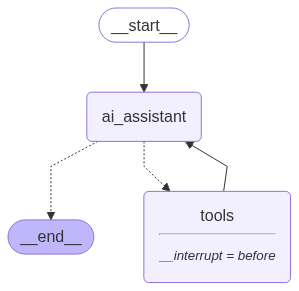

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [41]:
user_input = "Who is the current Prime Minister of India?"
config = {"configurable":{"thread_id":"1"}}

In [48]:
events = app.stream({"messages":[("user", user_input)]}, config, stream_mode="values")

In [49]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is the current Prime Minister of India?


TypeError: unhashable type: 'AIMessage'

In [50]:
snapshot = app.get_state(config)

In [51]:
snapshot.next

('ai_assistant',)

In [52]:
last_message = snapshot.values["messages"][-1]

In [ ]:
last_message.tool_calls

In [ ]:
# 'None' will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app.stream(None, config, stream_mode="values")

In [56]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is the current Prime Minister of India?


TypeError: unhashable type: 'AIMessage'